# Práctica 1: Familiarización

Está orientada esta práctica a los sistemas de medición. Se estudiaran 3 espectros de fuentes de rayos gamma de $^{137}Cs$, $^{60}Co$ y $^{22}Na$ fueron colocadas, una a una, sobre la nariz de un detector NaI (3'' $\times$ 3'') durante los tiempos de toma de datos $\Delta t$ listados en la Tabla. En esta misma Tabla están listados los archivos con los espectros resultantes.

| fuente $\gamma$ | $\Delta$ t (min) | archivo           |
|---------------|----------------|-----------------------|
| $^{137}Cs$      | 5              | Cs137_5minNaI.csv     |
| $^{60}Co$       | 10             | Co60_10minNaI.csv     |
| $^{22}Na$       | 10             | Na22_10minNaI.csv     |
---------------------------------------------------------



## Previo

Se importan los paquetes y se aplica el formato general


In [58]:
import numpy as np
from scipy.stats import poisson, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as wid
from scipy.optimize import curve_fit
import colorcet as cc

Se configuran las gráficas, tengase en cuenta que algunos pueden no cargar por dependencias a instalar pendientes.


In [59]:
%matplotlib widget
# plt.style.use("seaborn-v0_8-bright")
mpl.rcParams.update(
    {
        "legend.fontsize": 20,
        "axes.labelsize": 20,
        "axes.titlesize": 24,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "figure.titlesize": 24,
        "axes.titlepad": 10,
        "text.usetex": True,
        "font.family": "Times New Roman",
        "mathtext.fontset": "dejavusans",
        "font.size": 20,
        "axes.labelweight": "bold",
        "axes.grid.which": "both",
        "axes.grid": True,
        "grid.alpha": 0.5
    }
)

colors = cc.glasbey_dark
# Configuracion de colores
k = 0

# Rotar la lista: número positivo para rotar a la derecha, negativo para rotar a la izquierda
colors = colors[-k:] + colors[:-k]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

# Test
if False:
    plt.figure(figsize=(5, 5))
    plt.plot([1, 2, 3, 4], [1, 4, 9, 16], "o")
    plt.plot([4, 3, 2, 1], [1, 2, 3, 4], "o")
    plt.plot([1, 2, 3, 4], [1, 2, 3, 4], "s")
    plt.plot([4, 3, 2, 1], [1, 4, 9, 16], "s")
    plt.title("Test")
    plt.xlabel("X-axis Label", fontweight="bold")
    plt.ylabel("Y-axis Label")
    plt.show()

Importamos los archivos a utilizar!

In [60]:
# Importar CSVs por pandas
co60 = pd.read_csv("Co60_10minNaI.csv")
cs137 = pd.read_csv("Cs137_5minNaI.csv")
na22 = pd.read_csv("Na22_10minNaI.csv")

## 1. Cantidades Espectroscópicas Experimentales

### (a1) Ajuste Gaussiano Co60
Incluya Centroide $\mu$, desviación estándar $\sigma$, FWHM (canales) e intensidad $I$ (área)

##### Gráfica de ejemplo

<img src="ejemplo_co60.png" alt="alt text" width="500"/>

#### Gráfica


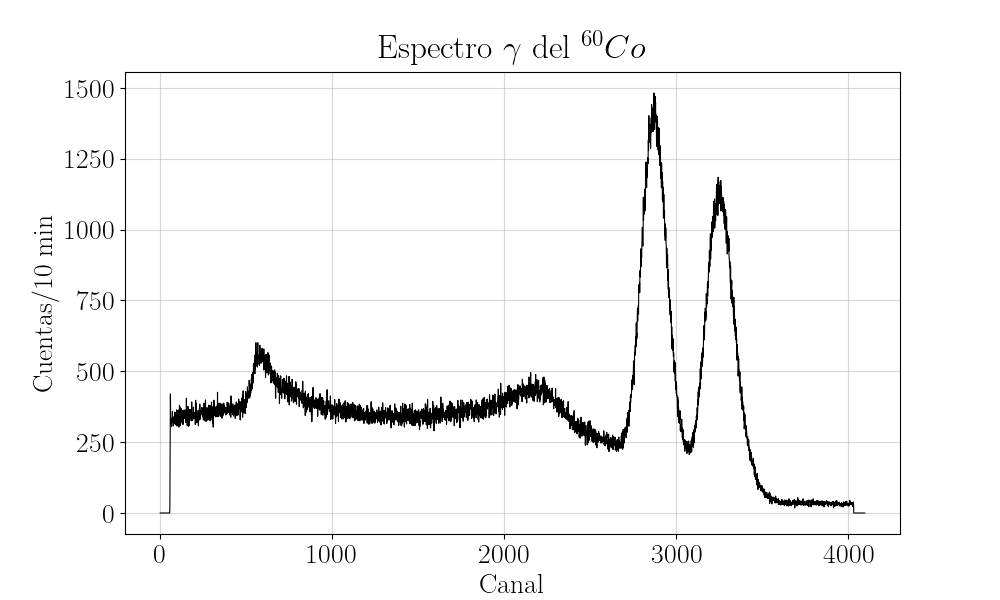

In [ ]:
# Gráfica
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Parámetros iniciales para gráfica
x = co60["canal"]
y = co60["cuentas"]
ax.set_xlabel('Canal')
ax.set_ylabel('Cuentas/10 min')
ax.set_title(r'Espectro $\gamma$ del $^{60}Co$')
ax.plot(x, y, color="black", lw=0.8)   # Espectro completo

ax.set_ylim(0, 900)
ax.set_xlim(400, 750)

#### Ajuste lineal (fondo no ambiental)

In [62]:
# -------------------------- Ajuste del fondo --------------------------
def background(x, a0, a1):  # funcion de ajuste
    return a0 + a1 * x

line_range = [[2413, 2650], [3587, 3590]]
x_fit = pd.concat([x[(x >= line_range[0][0]) & (x <= line_range[0][1])], x[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
y_fit = pd.concat([y[(x >= line_range[0][0]) & (x <= line_range[0][1])], y[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
popt, pcov = curve_fit(background, x_fit, y_fit, p0=[1000, -0.1])
a0, a1 = popt

def gauss_bg(x, mu, sigma, A,):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

# coords ajuste 1173.2keV
x_ranges= [[2650, 3080], [3080, 3587]]

# Espectro normal
ax.plot(x_fit, background(x_fit, *popt), label="Fondo") # Recta de fondo

#### Pico 1173 keV

In [63]:
# -------------------------- PICO 1: 1173.2 keV --------------------------
x_min, x_max = x_ranges[0]

# Filtrar los datos en el rango especificado
x_fit = x[(x >= x_min) & (x <= x_max)]
y_fit = y[(x >= x_min) & (x <= x_max)]

# ajuste
popt, pcov = curve_fit(gauss_bg, x_fit, y_fit, p0=[2873, 50, 1400])
ax.plot(x_fit, gauss_bg(x_fit, *popt), linestyle='-', label="1173.2 keV", color = colors[1], lw=1.5)

# Calcular el área bajo la curva gaussiana
mu, sigma, A= popt

# Calcular el área bajo la recta del fondo en ese rango
area_fondo = np.sum(background(x_fit, a0, a1))

# Calcular el área bajo la curva gaussiana
area_gauss_ajuste = A * sigma * np.sqrt(2 * np.pi)
area_gauss_real = np.sum(y[(x >= x_min) & (x <= x_max)]) - area_fondo

# Añadir el área al gráfico
ax.fill_between(x_fit, background(x_fit, a0, a1), gauss_bg(x_fit, *popt), color=colors[1], alpha=0.3)

# Mostrar los parámetros del ajuste
print(f"""Parámetros del ajuste PICO 1:
mu = {mu:.2f}
sigma = {sigma:.2f}
A = {A:.2f}
a0 = {a0:.2f}
a1 = {a1:.2f}
FMWH = {2.355 * sigma:.2f}
Área G. ajustada = {area_gauss_ajuste:.2f}
Área G. Real = {area_gauss_real:.2f}
""")


Parámetros del ajuste PICO 1:
mu = 2873.83
sigma = 72.36
A = 1207.55
a0 = 850.16
a1 = -0.23
FMWH = 170.41
Área G. ajustada = 219025.58
Área G. Real = 218343.46



#### Pico 1332 keV

In [64]:
# -------------------------- PICO 2: 1332.5 keV --------------------------
x_min, x_max = x_ranges[1]

# Filtrar los datos en el rango especificado
x_fit = x[(x >= x_min) & (x <= x_max)]
y_fit = y[(x >= x_min) & (x <= x_max)]

# ajuste
popt, pcov = curve_fit(gauss_bg, x_fit, y_fit, p0=[3244, 60, 1185])
ax.plot(x_fit, gauss_bg(x_fit, *popt), linestyle='-', label="1332.5 keV", color=colors[2])

# Calcular el área bajo la curva gaussiana
mu, sigma, A = popt
area_gaussiana = A * sigma * np.sqrt(2 * np.pi)

# Añadir el área al gráfico
ax.fill_between(x_fit, background(x_fit, a0, a1), gauss_bg(x_fit, *popt), color=colors[2], alpha=0.3)

# Mostrar los parámetros del ajuste
print(f"""Parámetros del ajuste PICO 2:
mu = {mu:.2f}
sigma = {sigma:.2f}
A = {A:.2f}
a0 = {a0:.2f}
a1 = {a1:.2f}
FMWH = {2.355 * sigma:.2f}
Área G. ajustada = {area_gaussiana:.2f}
Área G. Real = {np.sum(y[(x >= x_min) & (x <= x_max)]) - np.sum(background(x_fit, a0, a1)):.2f}
""")
ax.legend()

Parámetros del ajuste PICO 2:
mu = 3257.15
sigma = 81.22
A = 1010.37
a0 = 850.16
a1 = -0.23
FMWH = 191.27
Área G. ajustada = 205691.17
Área G. Real = 205278.01



#### Resumen

| Parámetro              | Pico 1        | Pico 2        |
|------------------------|---------------|---------------|
| $a_0$                  | 850.16        | 850.16        |
| $a_1$                  | -0.23         | -0.23         |
| $\mu$                  | 2873.83       | 3257.15       |
| $\sigma$               | 72.36         | 81.22         |
| $A$                    | 1207.55       | 1010.37       |
| $\text{FMWH}$          | 170.41        | 191.27        |
| $\text{Área G. ajustada}$ | 219025.58     | 205691.17     |
| $\text{Área G. Real}$  | 218343.46     | 205278.01     |



### (a2) Ajuste Gaussiano Cs137
Incluya Centroide $\mu$, desviación estándar $\sigma$, FWHM (canales) e intensidad $I$ (área)

##### Ejemplo

![alt text](ejemplo_Cs137.png)

#### Gráfica

In [65]:
# Parámetros iniciales para gráfica
x = cs137["canal"]
y = cs137["cuentas"]

Text(0.5, 1.0, 'Espectro $\\gamma$ del $^{137}Cs$')

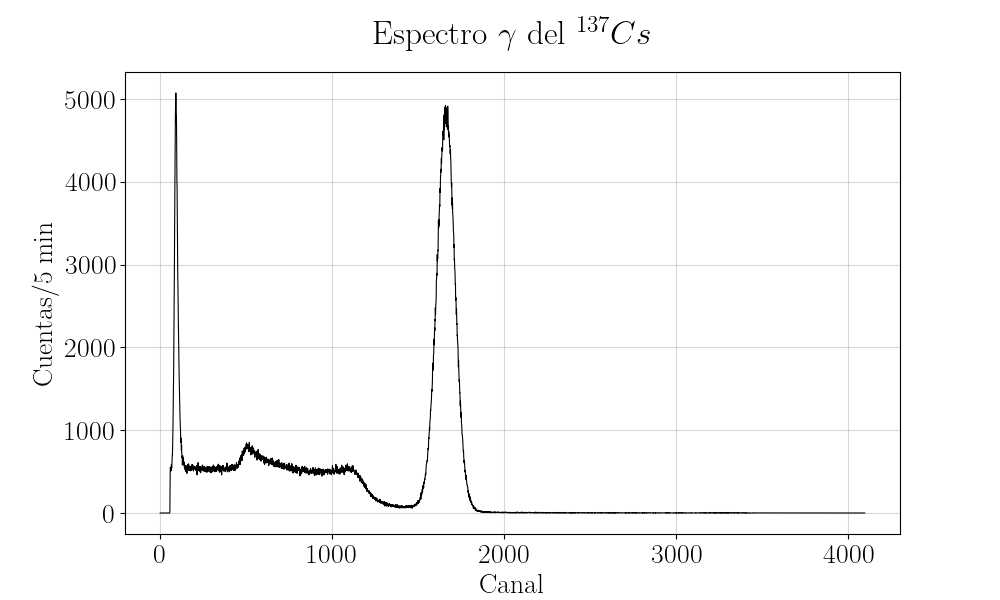

In [66]:
# Gráfica
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x, y, color="black", lw=0.8)   # Espectro completo
ax.set_xlabel('Canal')
ax.set_ylabel('Cuentas/5 min')
ax.set_title(r'Espectro $\gamma$ del $^{137}Cs$', pad=20)  # Añadir espacio entre el título y el cuadro de la gráfica

#### Ajuste de fondo para 662

In [67]:
# -------------------------- Ajuste del fondo --------------------------
x_min_gauss = 1413
x_max_gauss = 1867
# funcion de ajuste
def background(x, a0, a1):
    return a0 + a1 * x

line_range = [[1361, x_min_gauss], [1832, 1870]]
x_fit = pd.concat([x[(x >= line_range[0][0]) & (x <= line_range[0][1])], x[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
y_fit = pd.concat([y[(x >= line_range[0][0]) & (x <= line_range[0][1])], y[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
popt, pcov = curve_fit(background, x_fit, y_fit, p0=[100, -0.1])
a0, a1 = popt

def gauss_bg(x, mu, sigma, A,):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

# Espectro normal
ax.plot(x_fit, background(x_fit, *popt), label="Fondo", color=colors[1]) # Recta de fondo

# Imprimir el ajuste de la recta
print(f'''Ajuste de la recta de fondo:
a0 = {popt[0]:.2f}
a1 = {popt[1]:.2f}
''')

Ajuste de la recta de fondo:
a0 = 227.33
a1 = -0.11



#### Photopeak (662 keV)

In [68]:
# -------------------------- PICO 1: 662 keV --------------------------
x_min, x_max = x_min_gauss, x_max_gauss

# Filtrar los datos en el rango especificado
x_fit = x[(x >= x_min) & (x <= x_max)]
y_fit = y[(x >= x_min) & (x <= x_max)]

# ajuste
popt, pcov = curve_fit(gauss_bg, x_fit, y_fit, p0=[1652, 30, 5000])
ax.plot(x_fit, gauss_bg(x_fit, *popt), linestyle='-', label="662 keV", color = colors[1], lw=1.5)

# Calcular el área bajo la curva gaussiana
mu, sigma, A= popt
area_gaussiana = A * sigma * np.sqrt(2 * np.pi)

# Añadir el área al gráfico
ax.fill_between(x_fit, background(x_fit, a0, a1), gauss_bg(x_fit, *popt), color=colors[1], alpha=0.3)

# Mostrar los parámetros del ajuste
print(f"""Parámetros del ajuste PICO 1:
mu = {mu:.2f}
sigma = {sigma:.2f}
A = {A:.2f}
a0 = {a0:.2f}
a1 = {a1:.2f}
FMWH = {2.355 * sigma:.2f}
Área G. ajustada = {area_gaussiana:.2f}
Área G. Real = {np.sum(y[(x >= x_min) & (x <= x_max)]) - np.sum(background(x_fit, a0, a1)):.2f}
""")

Parámetros del ajuste PICO 1:
mu = 1661.50
sigma = 52.38
A = 4755.99
a0 = 227.33
a1 = -0.11
FMWH = 123.36
Área G. ajustada = 624494.76
Área G. Real = 626734.61



#### Pico Bario (32 keV)

In [69]:
color = 0
# -------------fondo bario-------------------
x_min, x_max = 152, 367
bg_bario = np.mean(y[(x >= x_min) & (x <= x_max)])
xx = x[(x >= 60) & (x <= x_max)]
plt.plot(xx, bg_bario*np.ones(len(xx)), color = colors[color])

a0, a1 = bg_bario, 0
def gauss_bg(x, mu, sigma, A,):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

# Imprimir el ajuste de la recta
print(f'''Ajuste de la recta de fondo:
a0 = {popt[0]:.2f}
a1 = {popt[1]:.2f}
''')

# -------------------------- PICO 1: 662 keV --------------------------
x_min, x_max = 71, 142

# Filtrar los datos en el rango especificado
x_fit = x[(x >= x_min) & (x <= x_max)]
y_fit = y[(x >= x_min) & (x <= x_max)]

# ajuste
popt, pcov = curve_fit(gauss_bg, x_fit, y_fit, p0=[80, 2, 5000])
ax.plot(x_fit, gauss_bg(x_fit, *popt), linestyle='-', label="32 keV", color = colors[color], lw=1.5)

# Calcular el área bajo la curva gaussiana
mu, sigma, A= popt
area_gaussiana = A * sigma * np.sqrt(2 * np.pi)

# Añadir el área al gráfico
ax.fill_between(x_fit, bg_bario*np.ones(len(x_fit)), gauss_bg(x_fit, *popt), color=colors[color], alpha=0.3)

# Mostrar los parámetros del ajuste
print(f"""Parámetros del ajuste PICO bario:
mu = {mu:.2f}
sigma = {sigma:.2f}
A = {A:.2f}
a0 = {a0:.2f}
a1 = {a1:.2f}
FMWH = {2.355 * sigma:.2f}
Área G. ajustada = {area_gaussiana:.2f}
Área G. Real = {np.sum(y[(x >= x_min) & (x <= x_max)]) - np.sum(background(x_fit, a0, a1)):.2f}
""")

ax.legend()

Ajuste de la recta de fondo:
a0 = 1661.50
a1 = 52.38

Parámetros del ajuste PICO bario:
mu = 93.31
sigma = 9.56
A = 4334.22
a0 = 536.23
a1 = 0.00
FMWH = 22.51
Área G. ajustada = 103838.92
Área G. Real = 107493.67



#### Resumen
| Parámetro               | Pico photopeak | Pico bario   |
|-------------------------|----------------|--------------|
| $a_0$                   | 227.33         | 536.23      |
| $a_1$                   | -0.11          | 0.00        |
| $\mu$                   | 1661.50        | 93.40        |
| $\sigma$                | 52.38          | 10.38        |
| $A$                     | 4755.99        | 4592.27      |
| $\text{FMWH}$           | 123.36         | 24.44        |
| $\text{Área G. ajustada}$ | 624494.76      | 119481.49    |
| $\text{Área G. Real}$   | 626734.61      | 118031.00    |


### (a3) Ajuste Gaussiano Na22
Incluya Centroide $\mu$, desviación estándar $\sigma$, FWHM (canales) e intensidad $I$ (área)

##### Ejemplo

![alt text](ejemplo_Na22.png)

#### Gráfica

In [70]:
# Parámetros iniciales para gráfica
x = na22["canal"]
y = na22["cuentas"]

Text(0.5, 1.0, 'Espectro $\\gamma$ del $^{22}$Na')

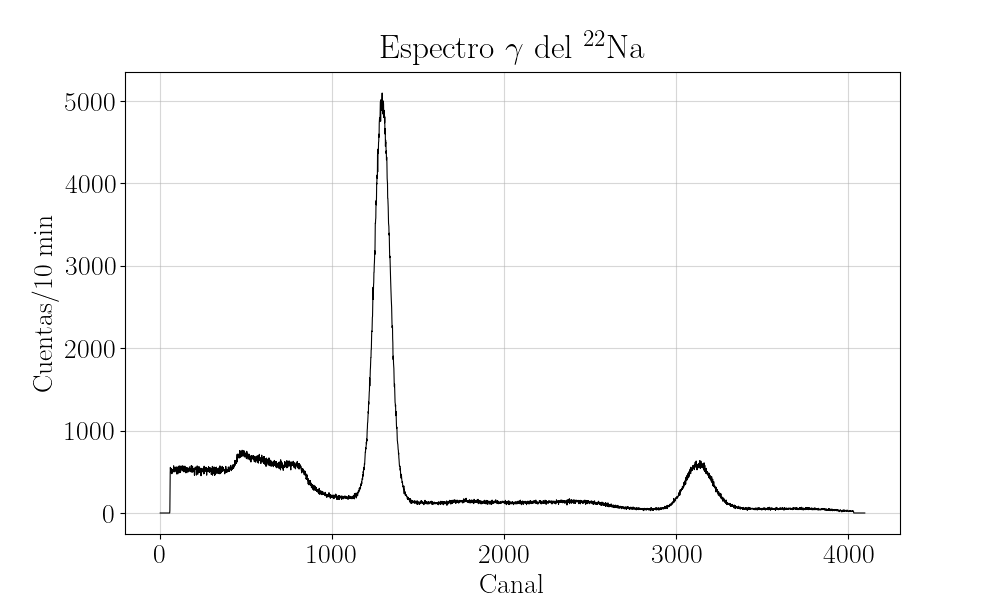

In [71]:
# Gráfica
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(x, y, color="black", lw=0.8)   # Espectro completo
ax.set_xlabel('Canal')
ax.set_ylabel('Cuentas/10 min')
ax.set_title(r'Espectro $\gamma$ del $^{22}$Na')

#### Ajuste de fondo 511 keV

In [72]:
color = 0
# -------------------------- Ajuste del fondo --------------------------
x_min_gauss = 1117
x_max_gauss = 1454
# funcion de ajuste
def background(x, a0, a1):
    return a0 + a1 * x

line_range = [[1024, x_min_gauss], [1466, 1600]]
x_fit = pd.concat([x[(x >= line_range[0][0]) & (x <= line_range[0][1])], x[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
y_fit = pd.concat([y[(x >= line_range[0][0]) & (x <= line_range[0][1])], y[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
popt, pcov = curve_fit(background, x_fit, y_fit, p0=[100, -0.1])
a0, a1 = popt

def gauss_bg(x, mu, sigma, A,):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

# Espectro normal
ax.plot(x_fit, background(x_fit, *popt), label="Fondo", color=colors[color]) # Recta de fondo

# Imprimir el ajuste de la recta
print(f'''Ajuste de la recta de fondo:
a0 = {popt[0]:.2f}
a1 = {popt[1]:.2f}
''')

Ajuste de la recta de fondo:
a0 = 333.84
a1 = -0.14



#### Photopeak-1 (511 keV)

In [73]:
# -------------------------- PICO 1: 662 keV --------------------------
x_min, x_max = x_min_gauss, x_max_gauss

# Filtrar los datos en el rango especificado
x_fit = x[(x >= x_min) & (x <= x_max)]
y_fit = y[(x >= x_min) & (x <= x_max)]

# ajuste
popt, pcov = curve_fit(gauss_bg, x_fit, y_fit, p0=[1268, 30, 5000])
ax.plot(x_fit, gauss_bg(x_fit, *popt), linestyle='-', label="511 keV", color = colors[color], lw=1.5)

# Calcular el área bajo la curva gaussiana
mu, sigma, A= popt
area_gaussiana = A * sigma * np.sqrt(2 * np.pi)

# Añadir el área al gráfico
ax.fill_between(x_fit, background(x_fit, a0, a1), gauss_bg(x_fit, *popt), color=colors[color], alpha=0.3)

# Mostrar los parámetros del ajuste
print(f"""Parámetros del ajuste PICO 1:
mu = {mu:.2f}
sigma = {sigma:.2f}
A = {A:.2f}
a0 = {a0:.2f}
a1 = {a1:.2f}
FMWH = {2.355 * sigma:.2f}
Área G. ajustada = {area_gaussiana:.2f}
Área G. Real = {np.sum(y[(x >= x_min) & (x <= x_max)]) - np.sum(background(x_fit, a0, a1)):.2f}
""")

Parámetros del ajuste PICO 1:
mu = 1290.83
sigma = 45.83
A = 4807.44
a0 = 333.84
a1 = -0.14
FMWH = 107.92
Área G. ajustada = 552237.50
Área G. Real = 555569.35



#### ajuste 1275

In [74]:
color = 1
# -------------------------- Ajuste del fondo --------------------------
x_min_gauss = 2800
x_max_gauss = 3400
# funcion de ajuste
def background(x, a0, a1):
    return a0 + a1 * x

x_min, x_max = 2720, 3760

line_range = [[x_min, x_min_gauss], [x_max_gauss, x_max]]
x_fit = pd.concat([x[(x >= line_range[0][0]) & (x <= line_range[0][1])], x[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
y_fit = pd.concat([y[(x >= line_range[0][0]) & (x <= line_range[0][1])], y[(x >= line_range[1][0]) & (x <= line_range[1][1])]])
popt, pcov = curve_fit(background, x_fit, y_fit, p0=[60, -0.01])
a0, a1 = popt

def gauss_bg(x, mu, sigma, A,):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

# Espectro normal
ax.plot(x_fit, background(x_fit, *popt), label="Fondo", color=colors[color]) # Recta de fondo

# Imprimir el ajuste de la recta
print(f'''Ajuste de la recta de fondo:
a0 = {popt[0]:.2f}
a1 = {popt[1]:.2f}
''')

Ajuste de la recta de fondo:
a0 = 59.65
a1 = -0.00



#### Photopeak-2 (1275 keV)

In [75]:
# -------------------------- PICO 1: 662 keV --------------------------
x_min, x_max = x_min_gauss, x_max_gauss

# Filtrar los datos en el rango especificado
x_fit = x[(x >= x_min) & (x <= x_max)]
y_fit = y[(x >= x_min) & (x <= x_max)]

# ajuste
popt, pcov = curve_fit(gauss_bg, x_fit, y_fit, p0=[3122, 50, 500])
ax.plot(x_fit, gauss_bg(x_fit, *popt), linestyle='-', label="511 keV", color = colors[color], lw=1.5)

# Calcular el área bajo la curva gaussiana
mu, sigma, A= popt
area_gaussiana = A * sigma * np.sqrt(2 * np.pi)

# Añadir el área al gráfico
ax.fill_between(x_fit, background(x_fit, a0, a1), gauss_bg(x_fit, *popt), color=colors[color], alpha=0.3)

# Mostrar los parámetros del ajuste
print(f"""Parámetros del ajuste PICO 1:
mu = {mu:.2f}
sigma = {sigma:.2f}
A = {A:.2f}
a0 = {a0:.2f}
a1 = {a1:.2f}
FMWH = {2.355 * sigma:.2f}
Área G. ajustada = {area_gaussiana:.2f}
Área G. Real = {np.sum(y[(x >= x_min) & (x <= x_max)]) - np.sum(background(x_fit, a0, a1)):.2f}
""")

Parámetros del ajuste PICO 1:
mu = 3132.02
sigma = 77.97
A = 538.84
a0 = 59.65
a1 = -0.00
FMWH = 183.62
Área G. ajustada = 105310.78
Área G. Real = 104645.62



#### Resumen
| Parámetro               | Pico 1        | Pico 2        |
|-------------------------|---------------|---------------|
| $a_0$                   | 333.84        | 59.65         |
| $a_1$                   | -0.14         | -0.00         |
| $\mu$                   | 1290.83       | 3132.02       |
| $\sigma$                | 45.83         | 77.97         |
| $A$                     | 4807.44       | 538.84        |
| $\text{FMWH}$           | 107.92        | 183.62        |
| $\text{Área G. ajustada}$ | 552237.50     | 105310.78     |
| $\text{Área G. Real}$   | 555569.35     | 104645.62     |



# Varios

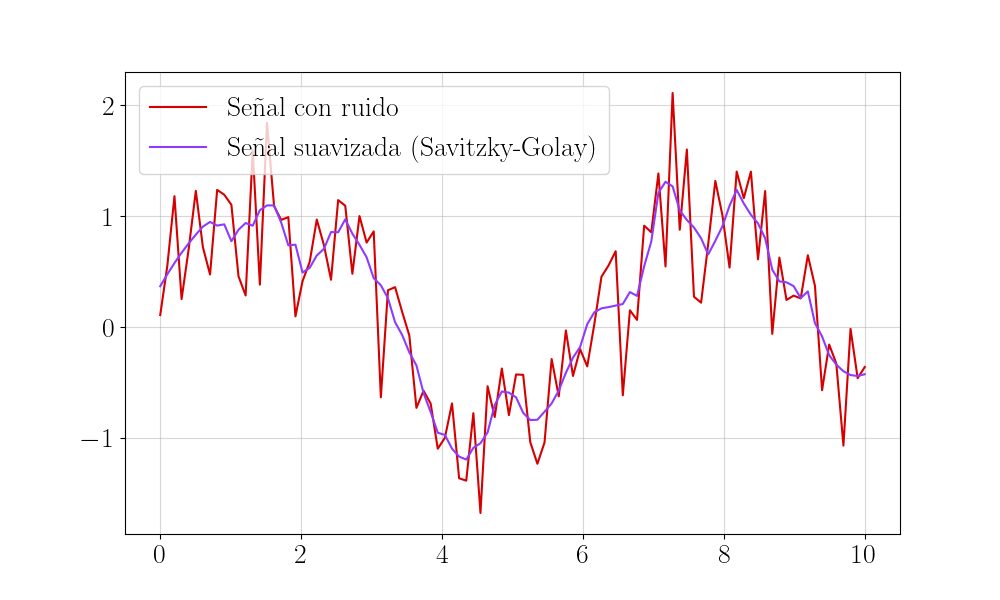

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Generar datos de ejemplo
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.5, x.size)

# Aplicar el filtro de Savitzky-Golay
y_smooth = savgol_filter(y, window_length=11, polyorder=2)

# Graficar la señal original y la suavizada
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Señal con ruido')
plt.plot(x, y_smooth, label='Señal suavizada (Savitzky-Golay)')
plt.legend()
plt.show()
